In [1]:
# reload magic
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mldec.datasets import toy_problem_data, single_round_code_data 
from mldec.models import baselines
from mldec.utils import evaluation

#### Toric code hyperparameter tuning analysis to see which hyperparameters were good
 
 - March 22 only-good-examples
    - lr=0.001 was perfect(!) - every model with this learning rate did perfectly on only-good
    - d_model >= 16 will be better
    - dim_feedforward 8,16 not good
TO REMOVE:
    - d_model=4,8, dim_feedforward=8,16,lr=0.0001, 0.005
    - dim_feedforward 8,16 not good

## Run analysis

#### Baseline: Weighted MWPM


In [6]:
ptrue = 0.01
var = 0.01
n = 7
dataset_config = {"p": ptrue, "var": var, "beta": 1.0, "dataset_module": "steane_code"}
X, Y, good_weights = single_round_code_data.uniform_over_good_examples(n, dataset_config)
X, Y, val_weights = single_round_code_data.create_dataset_training(n, dataset_config)

/Users/e6peters/projects/mldec/src/mldec/datasets/single_round_code_data.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, Y, probs = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), torch.tensor(probs, dtype=torch.float32)


In [7]:
error_probs = single_round_code_data.make_variance_noise_model(n, dataset_config, return_probs=True)
print("device qubit errors")
print(error_probs)
# for beta in np.linspace(0.75, 3, 10):
for beta in [1]:
    adjusted_probs = error_probs * beta
    adjusted_probs = np.ones(n) * ptrue * beta
    # minimum_weight_decoder = baselines.MinimumWeightPerfectMatching()
    # minimum_weight_decoder.make_decoder(None, None, error_probs=error_probs)
    # minimum_weight_val_acc = evaluation.weighted_accuracy(minimum_weight_decoder, X, Y, val_weights)
    # print("minweight acc: {}".format(minimum_weight_val_acc))


device qubit errors
[0.02717184 0.01324693 0.00525457 0.00862082 0.0152494  0.00642164
 0.00271795]


In [14]:
df_var_sweep = pd.read_csv("./results/transformer-fivequbit-code-v1.0/transformer_fivequbit_code_results.csv")

In [11]:
def ana_by_batch_size(df, col_name, quantile, append_inf=True):
    """For each value of batch_size, compute median and upper/lower quantile of df[col_name]."""
    batch_sizes = df['batch_size'].unique()
    # move 1994 to the end
    batch_sizes = np.array(list(sorted([x for x in batch_sizes if x != 1994])))
    if append_inf:
        batch_sizes = np.concatenate([batch_sizes, [1994]])
    medians = []
    lower_q = []
    upper_q = []
    for bs in batch_sizes:
        vals = 1 - df[df['batch_size'] == bs][col_name]
        medians.append(np.median(vals))
        lower_q.append(np.quantile(vals, 1-quantile))
        upper_q.append(np.quantile(vals, quantile))
    medians = np.array(medians)
    lower_q = medians - np.array(lower_q)
    upper_q = np.array(upper_q) - medians
    bounds = np.array(list(zip(lower_q, upper_q))).T
    return batch_sizes, medians, bounds

In [13]:
df_var["beta"].unique()

array([1, 2, 3])

In [16]:
quantile = 0.9
dct = {}
for beta in [1, 2, 3]:
    dct[beta] = ana_by_batch_size(df_var_sweep[df_var_sweep["beta"] == beta], "val_acc", quantile)

# batch_sizes, medians_beta, bounds_beta

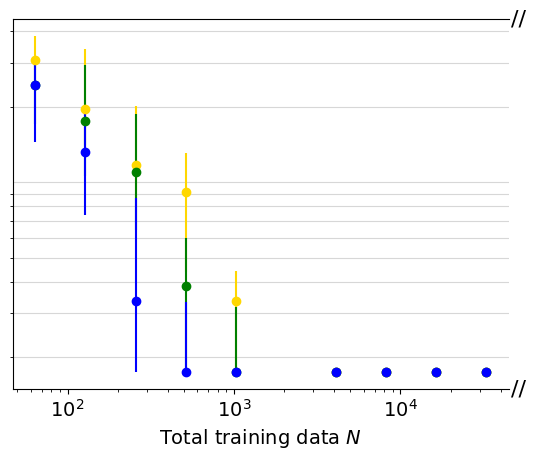

In [18]:
fig, ax2 = plt.subplots()

beta_colors = ["gold", "green", "blue"]
betas = [1, 2, 3]
novar_marker="x"
novar_alpha = 0.9
n_batches = 8 # the total training data is this time n_batches

for i in range(len(betas)):
    batch_sizes, medians_beta, bounds_beta = dct[betas[i]]
    color = beta_colors[i]
    ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta[:-1], yerr=bounds_beta[:,:-1], fmt='o', c=color)

ax2.annotate('//', xy=(1.02, 0),  xycoords='axes fraction', ha='center', va='center', fontsize=16)
ax2.annotate('//', xy=(1.02, 1),  xycoords='axes fraction', ha='center', va='center', fontsize=16)

ax2.loglog()
ax2.spines[['right']].set_visible(False)
ax2.set_xlabel(r"Total training data $N$", fontsize=14)

# ax2.set_ylabel(r"Median logical error rate")
# change xticklabel sizes
ax2.tick_params(axis='x', labelsize=14)
# put annotated '//' at y=0, x=xlim[1] in axis coordinates
ax2.grid(which='both', alpha=0.5, axis='y')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.tick_params(left=False, labelleft=False)


### MLD 'trained' on both the true distribution and the no-var distribution

In [8]:
# compute optimal performance on this dataset .9524514

mld = baselines.LookupTable()
mld.train_on_histogram(X, Y, good_weights)
mld_acc = evaluation.weighted_accuracy(mld, X, Y, val_weights) 
print(f"MLD table accuracy: {mld_acc}")

# compute the MLD for a no-variance depolarizing noise model
mld_for_novar = []
mld_for_var = []
betavals = sorted(df_novar['beta'].unique())
for beta in betavals:
    novar_dataset_config = {"p": ptrue, "var": 0, "beta": beta}
    var_dataset_config = {"p": ptrue, "var": var, "beta": beta}
    X, Y, good_novar = single_round_code_data.uniform_over_good_examples(n, novar_dataset_config)
    X, Y, good_var = single_round_code_data.uniform_over_good_examples(n, var_dataset_config)
    # train an MLD on the no-variance noise model, and then
    # evaluate on the "true" noise profile
    mld_novar = baselines.LookupTable()
    mld_novar.train_on_histogram(X, Y, good_novar)
    acc_novar = evaluation.weighted_accuracy(mld_novar, X, Y, val_weights)
    mld_for_novar.append(acc_novar)

    mld_var = baselines.LookupTable()
    mld_var.train_on_histogram(X, Y, good_var)
    acc_var = evaluation.weighted_accuracy(mld_var, X, Y, val_weights)
    mld_for_var.append(acc_var)

MLD table accuracy: 0.9985953569412231


/Users/e6peters/projects/mldec/src/mldec/models/baselines.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  return torch.tensor(out)


NameError: name 'df_novar' is not defined

In [10]:
#  DATA SWEEEP APRIL 11.A EXPERIMENT
# beta =[1, 1.75], var
target_var1 = "toric-code-var-exp-v3.1-datasweep/transformer_toric_code_results.csv"
df_var_sweep = pd.read_csv(target_var1)

# beta=[1, 1.75], novar
target_novar1 = "toric-code-novar-exp-v3.1-datasweep/transformer_toric_code_results.csv"
df_novarx = pd.read_csv(target_novar1)

# beta=3.25, novar
target_novar2 = "toric-code-novar-exp-v3.2-datasweep/transformer_toric_code_results.csv"
df_novar2x = pd.read_csv(target_novar2)
# combine df_novar2 into df_novar
df_novar_sweep = pd.concat([df_novarx, df_novar2x], ignore_index=True)

In [11]:
def ana_by_batch_size(df, col_name, quantile, append_inf=True):
    """For each value of batch_size, compute median and upper/lower quantile of df[col_name]."""
    batch_sizes = df['batch_size'].unique()
    # move 1994 to the end
    batch_sizes = np.array(list(sorted([x for x in batch_sizes if x != 1994])))
    if append_inf:
        batch_sizes = np.concatenate([batch_sizes, [1994]])
    medians = []
    lower_q = []
    upper_q = []
    for bs in batch_sizes:
        vals = 1 - df[df['batch_size'] == bs][col_name]
        medians.append(np.median(vals))
        lower_q.append(np.quantile(vals, 1-quantile))
        upper_q.append(np.quantile(vals, quantile))
    medians = np.array(medians)
    lower_q = medians - np.array(lower_q)
    upper_q = np.array(upper_q) - medians
    bounds = np.array(list(zip(lower_q, upper_q))).T
    return batch_sizes, medians, bounds

def ana_single_batch_size(df, col_name, quantile, batch_size):
    # add a single batch_size column to df
    df["batch_size"] = batch_size
    return ana_by_batch_size(df, col_name, quantile, append_inf=False)

quantile = 0.9
batch_sizes, medians_beta1, bounds_beta1 = ana_by_batch_size(df_var_sweep[df_var_sweep["beta"] == 1], "val_acc", quantile)
batch_sizes, medians_beta175, bounds_beta175 = ana_by_batch_size(df_var_sweep[df_var_sweep["beta"] == 1.75], "val_acc", quantile)
batch_sizes, medians_beta1_novar, bounds_beta1_novar = ana_by_batch_size(df_novar_sweep[df_novar_sweep["beta"] == 1], "val_acc", quantile)
batch_sizes, medians_beta175_novar, bounds_beta175_novar = ana_by_batch_size(df_novar_sweep[df_novar_sweep["beta"] == 1.75], "val_acc", quantile)
batch_sizes, medians_beta325_novar, bounds_beta325_novar = ana_by_batch_size(df_novar_sweep[df_novar_sweep["beta"] == 3.25], "val_acc", quantile)

_, medians_beta1_original, bounds_beta1_original = ana_single_batch_size(df_var[df_var["beta"] == 1], "val_acc", quantile, 10000)
_, medians_beta175_original, bounds_beta175_original = ana_single_batch_size(df_var[df_var["beta"] == 1.75], "val_acc", quantile, 10000)
_, medians_beta1_novar_original, bounds_beta1_novar_original = ana_single_batch_size(df_novar[df_novar["beta"] == 1], "val_acc", quantile, 10000)
_, medians_beta175_novar_original, bounds_beta175_novar_original = ana_single_batch_size(df_novar[df_novar["beta"] == 1.75], "val_acc", quantile, 10000)
_, medians_beta325_novar_original, bounds_beta325_novar_original = ana_single_batch_size(df_novar[df_novar["beta"] == 3.25], "val_acc", quantile, 10000)

C:\Users\peter\AppData\Local\Temp\ipykernel_11872\3105668356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["batch_size"] = batch_size


NameError: name 'df_var' is not defined

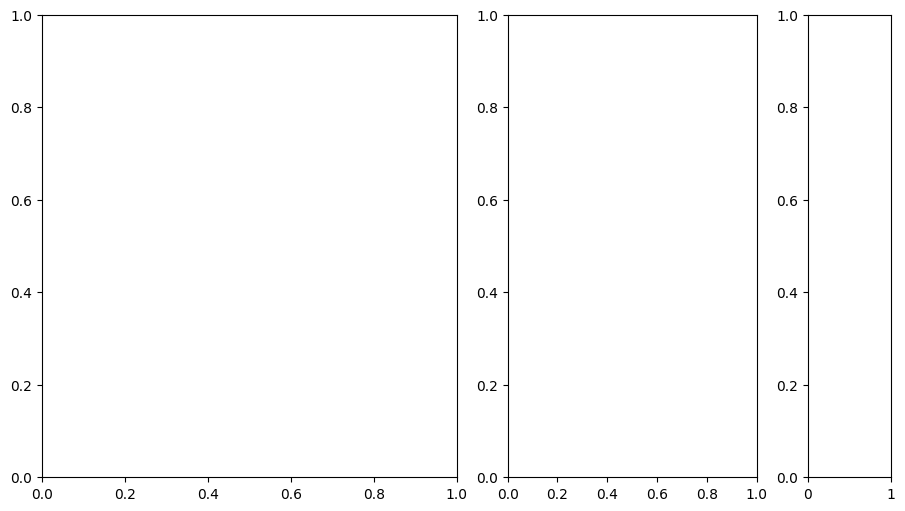

In [3]:
from matplotlib import gridspec
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(9, 5), constrained_layout=True)
gs = gridspec.GridSpec(1, 9, figure=fig)
# Its very frustrating that sharey here forces ylabels to appear.
ax = plt.subplot(gs[0, :5])
ax2 = plt.subplot(gs[0, 5:8])
ax3 = plt.subplot(gs[0, 8])

unwt_xformer_color = 'r'
wt_xformer_color = 'b'
wt_mwpm_color = 'grey'
wt_mld_color = 'purple'
unwt_mld_color = 'darkorange'
colors = [unwt_xformer_color, wt_xformer_color]
labels = [ r'unweighted $p_E[\beta p, 0]$', r'weighted $p_E[\beta p$, $' +"var" + r']$']
betavals = sorted(df_var['beta'].unique())

for jj, df in enumerate([df_novar, df_var]):
    color = colors[jj]
    # compute performance/stats on each of the models
    yerrs_meds = []
    yerrs_mins = []
    yerrs_ub = []
    yerrs_lb = []
    better_than_lookup_arr = [] # track when the model is better than the lookup table
    for i, beta in enumerate(betavals):
        y = df[df['beta'] == beta]['val_acc']
        y_err = 1 - y
        yerrs_meds.append(y_err.median())
        # get 
        y_ub = y_err.quantile(.75)
        y_lb = y_err.quantile(0.25)
        # y_ub = y_err.quantile(.95)
        # y_lb = y_err.quantile(0.05)
        # y_ub = max(y_err)
        # y_lb = min(y_err)
        yerrs_ub.append(y_ub)
        yerrs_lb.append(y_lb)
        yerrs_mins.append(y_err.min())

        # Also get the min weight performance
        # vs_minweight = df[df['beta'] == beta]['vs_minweight'].values
        # minweight = y - vs_minweight
        # min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...

        # now, find the comparison of this plot to the lookup table on the plot
        vs_lookup = df[df['beta'] == beta]['vs_lookup'][y.idxmax()]
        better_than_lookup = vs_lookup > 0
        better_than_lookup_arr.append(better_than_lookup)
    
    yerrs_meds = np.array(yerrs_meds)
    yerrs_mins = np.array(yerrs_mins)
    yerrs_ub = np.array(yerrs_ub)
    yerrs_lb = np.array(yerrs_lb)

    # xvals = ptrue * np.array(betavals)
    xvals = np.array(betavals)

    ax.fill_between(xvals, yerrs_lb, yerrs_ub, color=color, alpha=0.2)
    ax.plot(xvals, yerrs_meds, ls='--', marker=None, c=color, alpha=0.7)
    ax.plot(xvals, yerrs_mins, ls='-', marker=None, c=color, label=labels[jj])
    # wherever the result is better than lookup, plot a star
    for i, beta in enumerate(betavals):
        if better_than_lookup_arr[i]:
            marker = '*'
            markersize = 9
        else:
            marker = 'o'
            markersize = 6
        ax.plot(xvals[i], yerrs_mins[i], marker=marker, c=color, markersize=markersize)

    if jj ==1:
        ax.axhline(1 - minimum_weight_val_acc, ls=':', c=wt_mwpm_color, alpha=0.7)
        ax.text(1.1, 1 - minimum_weight_val_acc, "MWPM", color=wt_mwpm_color, va='bottom', ha='left', fontsize=10, alpha=0.7)
        ax.plot(xvals, 1 - np.array(mld_for_var), ls=':', c=wt_mld_color, alpha=0.9)
        ax.text(1, 1 - mld_for_var[0] + 0.0001, r"MLD (wt)", color=wt_mld_color, va='bottom', ha='left', fontsize=10, alpha=0.9)
        ax.plot(xvals, (1 - np.array(mld_for_novar))[:len(xvals)], ls=':', c=unwt_mld_color, alpha=1)
        ax.text(1.4, 1 - mld_for_novar[0], r"MLD (unwt)", color=unwt_mld_color, va='bottom', ha='left', fontsize=10, alpha=1)

    ax.semilogy()
    ax.set_xlabel(r"Knob factor $\beta$", size=14)

ax.set_ylim([ax.get_ylim()[0], 1 - minimum_weight_val_acc + 1e-3])
# ax.set_ylim([3e-2, 6e-2])
ax.set_ylabel("Logical Error Probability (LEP)", size=14)
# place the legend at (0.7, 0.9) using axis coordinates
ax.legend(loc="upper left", fontsize=10, framealpha=1, bbox_to_anchor=(0.3, 0.8))

# bar plots of the best performance from each category
def best_median_iq_beta(df, beta):
    if beta:
        df = df[df['beta'] == beta]
    else:
        # slice the df to keep only the beta corresponding to maximum val acc
        beta = df.loc[df['val_acc'].idxmax()]['beta']
        df = df[df['beta'] == beta]
    y = df['val_acc']
    errs = 1 - y
    best = errs.min()
    median = errs.median()
    iq = (errs.quantile(0.1), errs.quantile(0.90))
    return best, median, iq

wt_beta1_best, wt_beta1_median, wt_beta1_iq = best_median_iq_beta(df_var, beta=1)
wt_best, wt_median, wt_iq = best_median_iq_beta(df_var, beta=None)
unwt_best, unwt_median, unwt_iq = best_median_iq_beta(df_novar, beta=None)
print(f"unweighted beta=1: {wt_beta1_best}, {wt_beta1_median}, {wt_beta1_iq}")
print(f"weighted best: {wt_best}, {wt_median}, {wt_iq}")
print(f"unweighted best: {unwt_best}, {unwt_median}, {unwt_iq}")
mld_err = 1 - mld_acc
mwpm_err = 1 - minimum_weight_val_acc
mld_unwt_err = 1 - max(mld_for_novar) # this doesn't matter, they're all the same
ax.grid(which='both', alpha=0.5, axis='y')

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# second plot is for n_train sweep
# define three shades of red: (pink, red, dark red)
red_rgb = "gold"
red_rgb2 = "orange"
red_rgb3 = "red"

novar_marker="x"
novar_alpha = 0.9

n_batches = 32 # the total training data is this time n_batches
ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta1[:-1], yerr=bounds_beta1[:,:-1], fmt='o', c='cyan')
ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta175[:-1], yerr=bounds_beta175[:,:-1], fmt='o', c='b')
ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta325_novar[:-1], yerr=bounds_beta325_novar[:,:-1], fmt=novar_marker, c=red_rgb3, alpha=novar_alpha)
ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta175_novar[:-1], yerr=bounds_beta175_novar[:,:-1], fmt=novar_marker, c=red_rgb2, alpha=novar_alpha)
ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta1_novar[:-1], yerr=bounds_beta1_novar[:,:-1], fmt=novar_marker, c=red_rgb, alpha=novar_alpha)

ax2.annotate('//', xy=(1.02, 0),  xycoords='axes fraction', ha='center', va='center', fontsize=16)
ax2.annotate('//', xy=(1.02, 1),  xycoords='axes fraction', ha='center', va='center', fontsize=16)

# also plot original data
ax2.errorbar(10000, medians_beta1_original[-1], yerr=bounds_beta1_original[:,-1].reshape(2,1), fmt='o', c='cyan', label=r'$\beta=1$ (weighted)')
ax2.errorbar(10000, medians_beta175_original[-1], yerr=bounds_beta175_original[:,-1].reshape(2,1), fmt='o', c='b', label=r'$\beta=1.75$ (weighted)')
ax2.errorbar(10000, medians_beta325_novar_original[-1], yerr=bounds_beta325_novar_original[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb3, label=r'$\beta=3.25$ (unweighted)', alpha=novar_alpha)
ax2.errorbar(10000, medians_beta175_novar_original[-1], yerr=bounds_beta175_novar_original[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb2, label=r'$\beta=1.75$ (unweighted)', alpha=novar_alpha)
ax2.errorbar(10000, medians_beta1_novar_original[-1], yerr=bounds_beta1_novar_original[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb, label=r'$\beta=1$ (unweighted)', alpha=novar_alpha)

ax2.loglog()
ax2.spines[['right']].set_visible(False)
ax2.set_xlabel(r"Total training data $N$", fontsize=14)

# ax2.set_ylabel(r"Median logical error rate")
# change xticklabel sizes
ax2.tick_params(axis='x', labelsize=14)
# put annotated '//' at y=0, x=xlim[1] in axis coordinates
ax2.grid(which='both', alpha=0.5, axis='y')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.tick_params(left=False, labelleft=False)

# ax2.set_yticklabels([])
# print(ax.get_yticks())
# ax2.set_yticks(ax.get_yticks())
ax2.set_ylim(ax.get_ylim()[0], 7e-2)
ax2.legend(loc="upper right", fontsize=9, framealpha=1, bbox_to_anchor=(.99, 0.99))

# prettier sci not
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # This controls when to use scientific notation
for axis in [ax, ax2]:
    axis.yaxis.set_major_formatter(formatter)
    axis.yaxis.set_minor_formatter(formatter)
    axis.yaxis.offsetText.set_visible(True)
    axis.yaxis.get_offset_text().set_position((-0.02, 0))  # Adjust position as needed
    axis.yaxis.get_offset_text().set_size(10)


ax2.axhline(1 - minimum_weight_val_acc, ls=':', c=wt_mwpm_color, alpha=0.7)
ax3.axhline(1 - minimum_weight_val_acc, ls=':', c=wt_mwpm_color, alpha=0.7)
ax2.text(1e4, 1 - minimum_weight_val_acc, "MWPM", color=wt_mwpm_color, va='bottom', ha='left', fontsize=10, alpha=0.7)
ax2.axhline(1 - mld_for_var[0], ls=':', c=wt_mld_color, alpha=0.9)
ax3.axhline(1 - mld_for_var[0], ls=':', c=wt_mld_color, alpha=0.9)
ax2.text(200, 1 - mld_for_var[0] + 0.0001, r"MLD (wt)", color=wt_mld_color, va='bottom', ha='left', fontsize=10, alpha=0.9)
ax2.axhline((1 - mld_for_novar[0]), ls=':', c=unwt_mld_color, alpha=1)
ax3.axhline((1 - mld_for_novar[0]), ls=':', c=unwt_mld_color, alpha=1)
ax2.text(200, 1 - mld_for_novar[0], r"MLD (unwt)", color=unwt_mld_color, va='bottom', ha='left', fontsize=10, alpha=1)

ax3.semilogy()
ax3.errorbar(1, medians_beta1[-1], yerr=bounds_beta1[:,-1].reshape(2,1), fmt='o', c='cyan', label=r'$\beta=1$, var (weighted)')
ax3.errorbar(1, medians_beta175[-1], yerr=bounds_beta175[:,-1].reshape(2,1), fmt='o', c='b', label=r'$\beta=1.75$, var (weighted)')
ax3.errorbar(1, medians_beta325_novar[-1], yerr=bounds_beta325_novar[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb3, label=r'$\beta=3.25$ (unweighted)', alpha=novar_alpha)
ax3.errorbar(1, medians_beta175_novar[-1], yerr=bounds_beta175_novar[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb2, label=r'$\beta=1.75$ (unweighted)', alpha=novar_alpha)
ax3.errorbar(1, medians_beta1_novar[-1], yerr=bounds_beta1_novar[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb, label=r'$\beta=1$ (unweighted)', alpha=novar_alpha)
ax3.spines[['left']].set_visible(False)

# suppress y-axis on ax3 and ticks
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.get_yminorticklabels(), visible=False)  # <--- THIS IS IT! FOUND IT.
# ax3.tick_params(left=False, labelleft=False)
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.set_xticks([1])
ax3.set_xticklabels([r"$\infty$"], fontsize=16)
ax3.set_ylim(ax2.get_ylim())
ax3.grid(which='both', alpha=0.5, axis='y')



fig.savefig(f"../../figures/fig2_bc.pdf", bbox_inches='tight')

### Overflow pictures

#### Accuracy distributions of transformers lookup table

(-0.005, 0.012)

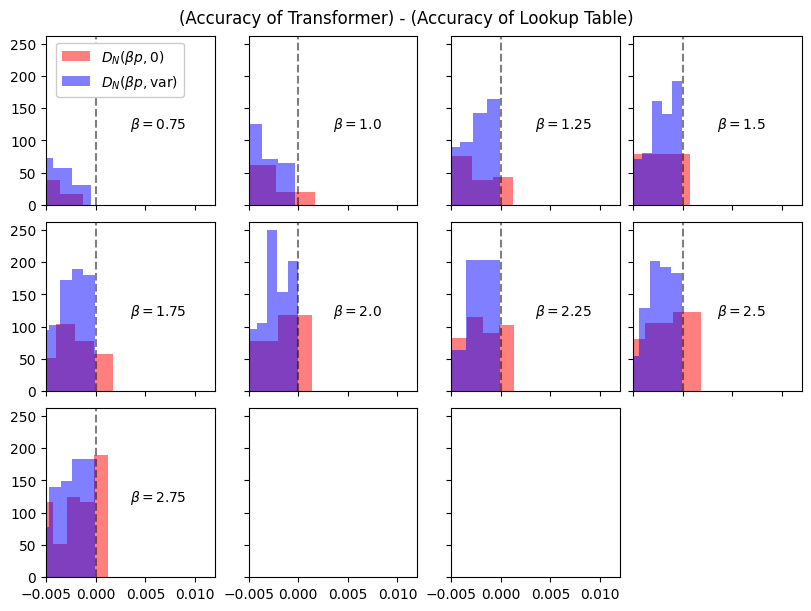

In [13]:
# make a 2D histogram of transformer vs_lookup versus betas
betavals = sorted(df_var['beta'].unique())
all_betas = []
lookup_vals_var = []
lookup_vals_novar = []
for beta in betavals:
    vs_lookupvals_var = df_var[df_var['beta'] == beta]['vs_lookup'].values
    lookup_vals_var.append(vs_lookupvals_var)
    vs_lookupvals_novar = df_novar[df_novar['beta'] == beta]['vs_lookup'].values
    lookup_vals_novar.append(vs_lookupvals_novar)

fig, axes = plt.subplots(3, 4, figsize=(8, 6), constrained_layout=True, sharex=True, sharey=True)
ax = axes.flatten()
for i in range(len(betavals)):
    beta = betavals[i]
    vals_var = lookup_vals_var[i]
    vals_novar = lookup_vals_novar[i]
    ax[i].hist(vals_novar, alpha=0.5, color='r', label=r"$D_N(\beta p, 0)$", density=True)
    _, bins, _ = ax[i].hist(vals_var, bins=20, alpha=0.5, color='b', label=r"$D_N(\beta p, \text{var})$", density=True)
    # put text with beta value in the axis
    ax[i].text(0.5, 0.45, r"$\beta=$"+f"{beta}", transform=ax[i].transAxes)
    # break
    # ax[i].set_title(f"beta={beta}")
    ax[i].axvline(0, ls='--', c='k', alpha=0.5)

ax[-1].set_visible(False)
fig.suptitle("(Accuracy of Transformer) - (Accuracy of Lookup Table)")
ax[0].legend(bbox_to_anchor=(0.02, 1), loc="upper left", framealpha=1)
ax[0].set_xlim([-0.005, 0.012])
# fig.savefig(f"../../figures/agg_toric_code_vs_lookup.pdf", bbox_inches='tight')
